# Aprendizaje automático relacional con extracción manual de características

A continuación, se abordará la tarea de predecir si un usuario es un desarrollador de Machine Learning o un desarrollador web a partir de sus relaciones en el grafo. Se seguirán tres enfoques diferentes para llevar a cabo esta tarea: ML con extracción manual de características, ML con extracción automática de características y Graph Neuronal Networks. En este notebook se abordará el primero de estos enfoques y los otros enfoques se desarrollarán en los dos notebooks siguientes.

Tenemos por tanto una tarea de clasificación binaria con una dificultad añadida, que como se ha comentado en el análisis previo, **el dataset no está balanceado**, ya que hay 27961 nodos de la clase 0 frente a 9739 nodos de la clase 1. Esto hace necesario considerar el uso de ténicas de remuestreo y de métricas de evaluación específicas.

Para entrenar los modelos, se considerarán las 5 métricas de cada nodo calculadas en el notebook anterior: el grado, el coeficiente de clustering, la centralidad closeness, la centralidad betweenness y el pagerank. Se trabajará con una partición en entrenamiento test, para entrenar los modelos y evaluar la capacidad de generaliazción de estos. Se empleará validación cruzada dentro del conjunto de entrenamiento para ajustar los valores de los hiperparámetros y seleccionar el método de remuestreo más adecuado para cada caso.


Comenzamos importando las librerías necesarias

In [19]:
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline


from utils import plot_corrmat


## Data import

Se carga el conjunto de features extraídas manualmente que está compuesto por las métricas calculadas en el notebook anterior para cada nodo. Igualmente, se toma la variable objetivo del conjunto *target*.

In [10]:
X = pd.read_csv("../data/processed/X_selected_features.csv")

target = pd.read_csv("../data/raw/musae_git_target.csv")
y = pd.Categorical(target["ml_target"])

Vemos que se trata de un dataframe con 37700 muestras  y 5 variables.

In [11]:
X.shape

(37700, 5)

Para hacernos una primera idea del conjunto de datos que tenemos, vamos a calcular una representación de este en 2 dimensiones empleando el método de incrustación de vecinos estocásticos distribuidos en t (t-SNE). Hay que tener en cuenta que para que el método funcione correctamente se deben normalizar las variables.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(X_scaled)

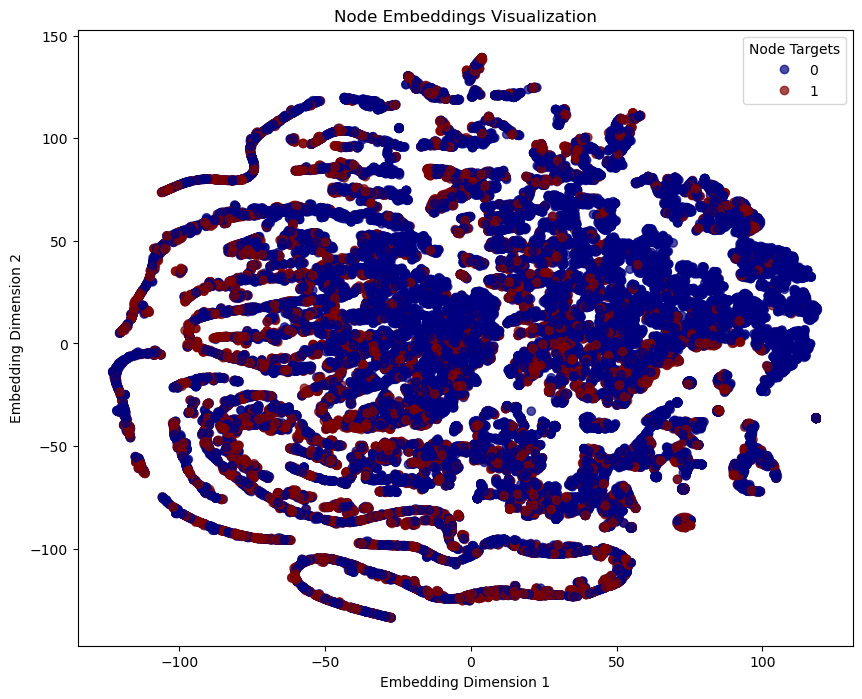

In [6]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(y))}
node_colours = [label_map[target] for target in y]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

# Add a legend
legend_labels = [str(label) for label in np.unique(y)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Targets", loc="best")


# Show the plot
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Node Embeddings Visualization")
plt.show()

A primera vista, en esta primera representación (algo extraña), no se observa una clara separación de las clases, lo que nos hace pensar que puede ser complicado obtener buenos resultados en la tarea que tenemos entre manos. Veamos.

Recordamos que tenemos un dataset no balanceado con una relación de 3 a 1 entre las clases.

In [13]:
# dataset no balanceado... problemas
y.value_counts()/len(y)

0    0.741671
1    0.258329
Name: count, dtype: float64

Veamos un resumen estadístico de las variables:

In [14]:
X.describe()

,degree,clustering,closeness,pagerank,betweenness
count,37700.000000,37700.000000,37700.000000,3.770000e+04,3.770000e+04
mean,0.000407,0.167537,0.313667,2.372860e-03,5.958963e-05
std,0.002143,0.225168,0.040806,4.571137e-03,1.949917e-03
min,0.000027,0.000000,0.141389,3.543991e-12,0.000000e+00
25%,0.000053,0.000000,0.284141,1.671726e-04,4.495291e-08
50%,0.000159,0.100000,0.311260,1.083887e-03,1.529294e-06
75%,0.000345,0.226316,0.346949,3.186920e-03,1.728025e-05
max,0.250882,1.000000,0.523081,3.559468e-01,2.695983e-01


Se puede observar que las variables presentan diferentes escaladas y no están centradas. Esto se tendrá en cuenta para los modelos en los que se requiera que los datos estén normalizados para evitar que unas variables tengan más pesos que otras en la clasificación.

Veamos a continuación las correlaciones entre las variables:

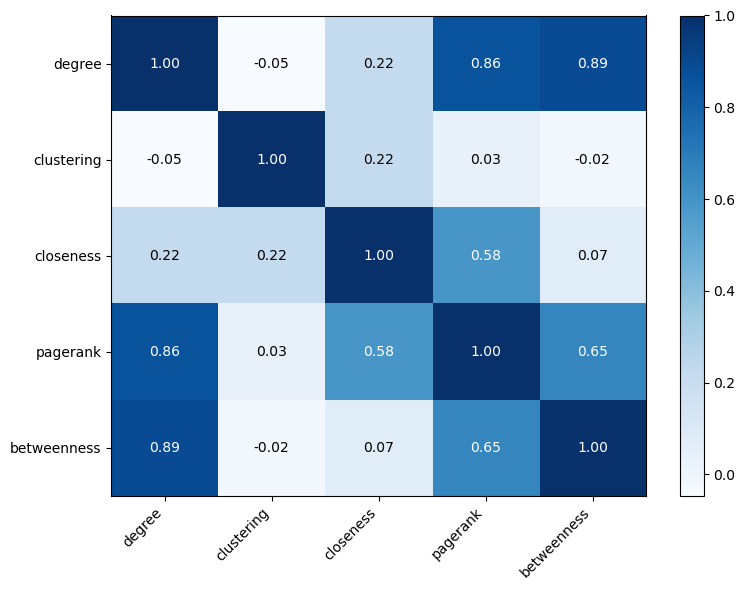

In [15]:
# Correlaciones elevadas... más problemas
corr = X.corr()
plot_corrmat(corr)

Como cabía esperar se observa correlaciones muy elevadas entre algunos pares de variables:
- *degree* y *betweenness* tienen una correlación de 0.89
- *degree* y *pagerank* tienen una correlación de 0.86
- *betweenness* y *pagerank* tienen una correlación de 0.65

Esto habrá que tenerlo en cuenta para los modelos en los que la multicolinealidad sea un problema, como en la regresión logística. Será necesario considerar algún parámetro de regularización.

## Partición entrenamiento - test

Se realiza una partición aleatoria del conjunto de datos en entrenamiento y test.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=0)

## Métodos de remuestreo

Una alternativa muy común a la hora de enfrentarse a problemas de clasificación con datos no balanceados es emplear métodos de remuestreo para obtener una muestra balanceada que nos permita entrenar los modelos evitando sesgos. Existen 3 tipos de métodos de remuestreo diferentes:
- ***Over-sampling***: Consiste en aumentar la cantidad de ejemplos en la clase minoritaria replicándolos o generando nuevos datos sintéticos. Una técnica común es SMOTE (Synthetic Minority Over-sampling Technique), que crea ejemplos sintéticos interpolando entre los datos existentes.

- ***Under-sampling***: Se reduce el número de ejemplos de la clase mayoritaria eliminando datos. Esto busca equilibrar las clases reduciendo el sesgo, pero puede implicar pérdida de información si se eliminan datos relevantes.

- **Combinación de *over-sampling* y *under-sampling***: Combina ambas estrategias para mitigar las limitaciones de cada una. Se suelen generar nuevos datos sintéticos en la clase minoritaria (*over-sampling*) y, simultáneamente, se reduce la cantidad de datos en la clase mayoritaria (*under-sampling*), buscando un balance entre mantener representatividad y evitar redundancia o pérdida de información.

En una prueba preliminar se consideraron todos los métodos de remuestreos que aparecen en la celda siguiente, que aparece comentada.

In [17]:
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
# from imblearn.combine import SMOTEENN, SMOTETomek

# X_train_resamp, y_train_resamp = SMOTE().fit_resample(X_train,y_train)
# X_train_oversamp, y_train_oversamp = ADASYN().fit_resample(X_train,y_train)


# X_train_undersamp, y_train_undersamp = RandomUnderSampler().fit_resample(X_train,y_train)
# X_train_undersamp, y_train_undersamp = ClusterCentroids().fit_resample(X_train,y_train)
# nm1 = NearMiss(version=1)
# X_train_undersamp, y_train_undersamp = nm1.fit_resample(X_train,y_train)

# X_train_samp, y_train_samp = SMOTEENN().fit_resample(X_train,y_train)
# X_train_samp, y_train_samp = SMOTETomek().fit_resample(X_train,y_train)

Sin embargo, no era viable considerar todos estos métodos para cada uno de los modelos, por lo que se optó por seleccionar el modelo de cada tipo de remuestreo que dio mejores resultados: ADASYN dentro de los métodos de *over-sampling*, NM1 en el caso de los métodos de *under-sampling* y SMOTETomek entre los métodos mixtos.

Todos estos métodos de remuestreo los proporciona la librería *imblearn*, cuya documentación puede consultarse en el siguiente enlace: https://imbalanced-learn.org/stable/index.html.

## Métrica de evaluación
La métrica principal considerada para evaluar el rendimiento de los modelos durante el ajuste de hiperparámetros y en el conjunto test, será el *balanced_accuracy* o tasa de acierto equilibrada. No es más que la media del recall en cada clase, es decir, la media de las tasas de acierto en cada clase. Esto es fundamental, ya que estamos trabajando con un conjunto de datos no equilibrados.

## Modelos
Se han considerado los modelos de *Decision Tree*, *Random Forest*, Regresión logística *elastic net* y SVM.

La metodología seguida ha sido la misma en todos los casos:

1. Definir el modelo.
2. Definir el pipeline para el preprocesamiento y el modelado, con el objetivo de asegurar la consistecia durante el entrenamiento y la predicción. El pipeline está compuesto por:
    1. Scaler, aunque algunos modelos no necesiten el reescalado, este es imprescindible para los métodos de remuestreo considerados.
    2. Remuestreo. Al emplear métodos de remuestreo basados en distancia, estos son sensible a la heterocedasticidad de los datos. Es por ello que se remuestrea después de reescalar los datos.
    3. Modelo.
3. Ajustar los parámetros del modelo mediante validación cruzada. Entre los parámetros del modelo se ha considerado el tipo de remuestreo a emplear, ya que según el caso y el modelo un tipo de remuestreo puede ser preferible a otro.

Emplear validación cruzada en el ajuste de los modelos nos asegura que tomamos la mejor combinación de parámetros. Sin embargo, el costo computacional de esto es elevado.


### Decision Tree

In [21]:
dt = tree.DecisionTreeClassifier(random_state=0)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('resampler', None),         
    ('model', dt)  
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [None, ADASYN(random_state=0), NearMiss(version=1), SMOTETomek(random_state=0)],  # Resampling methods
    'model__max_depth': list(range(3,15)),  
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('resampler', None),
                                       ('model',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                              13, 14],
                         'resampler': [None, ADASYN(random_state=0), NearMiss(),
                                       SMOTETomek(random_state=0)]},
             scoring='balanced_accuracy', verbose=1)

0.6808205132906712


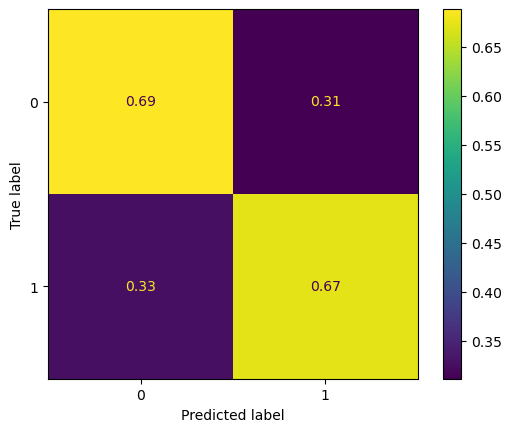

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, balanced_accuracy_score

y_pred = grid.predict(X_test)


print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase


disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()

In [ ]:
# dt = tree.DecisionTreeClassifier(max_depth=grid.best_params_["model__max_depth"])
# dt.fit(X_train,y_train)
# plt.figure(figsize=(12,12))
# tree.plot_tree(dt)

### Random forest

In [19]:
rf = RandomForestClassifier(random_state=0)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Step 1: Scaling
    ('resampler', None),          # Step 2: Placeholder for resampling
    ('model', rf)  # Step 3: Logistic Regression
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [None, ADASYN(random_state=0), NearMiss(version=1), SMOTETomek(random_state=0)],  # Resampling methods
    'model__max_depth': list(range(3,16,3)),
    'model__n_estimators':  [100,200,300,400]
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('resampler', None),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [3, 5, 7, 9],
                         'model__n_estimators': [10, 50, 100, 200],
                         'resampler': [None, ADASYN(), NearMiss(),
                                       SMOTETomek()]},
             scoring='balanced_accuracy', verbose=1)

In [21]:
# max_depth=9, n_stimators=200

0.6914317306396817


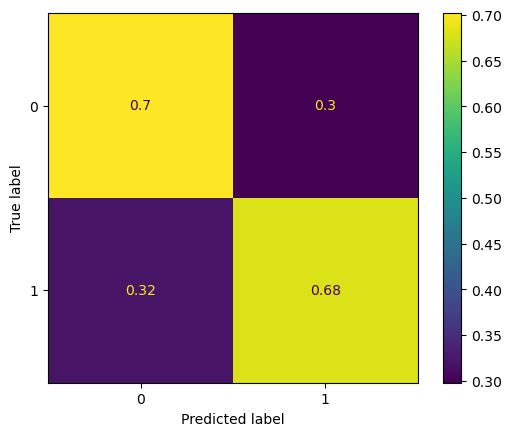

In [20]:
y_pred = grid.predict(X_test)


print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase


disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()

### Logistic regresion

In [55]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="elasticnet", solver="saga",random_state=0) # saga is an stochastic optimizer

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Step 1: Scaling
    ('resampler', None),          # Step 2: Placeholder for resampling
    ('model', lr)  # Step 3: Logistic Regression
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [None, ADASYN(random_state=0), NearMiss(version=1), SMOTETomek(random_state=0)],  # Resampling methods
    'model__C':  [0.1,0.5,1,5,10], # Inverse of regularization stregth, smaller values more regu
    'model__l1_ratio':  [0,0.5,1]
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('resampler', None),
                                       ('model',
                                        LogisticRegression(penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=1,
             param_grid={'model__C': [0.1, 0.5, 1, 5, 10],
                         'model__l1_ratio': [0, 0.5, 1],
                         'resampler': [None, ADASYN(), NearMiss(),
                                       SMOTETomek()]},
             scoring='balanced_accuracy', verbose=1)

0.606651401859531


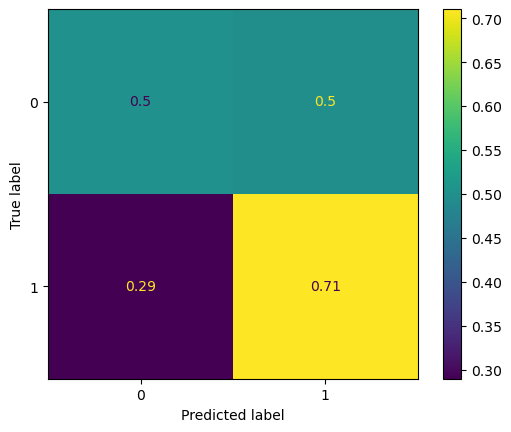

In [53]:
y_pred = grid.predict(X_test)

print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase

disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()

### SVM

In [ ]:
svc = SVC(random_state=0)

# Define the pipeline
pipeline = Pipeline([
    ('resampler', None),          # Step 1: Placeholder for resampling
    ('scaler', StandardScaler()),    # Step 2: Scaling
    ('model', svc)  # Step 3: Logistic Regression
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [None, ADASYN(random_state=0), NearMiss(version=1), SMOTETomek(random_state=0)],  # Resampling methods
    'model__kernel': ["linear", "poly","rbf","sigmoid"],
    'model__C':  [0.5,1,5] # Regularization parameter. The strength of the regularization is inversely proportional to C.
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=8)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('resampler', None),
                                       ('scaler', StandardScaler()),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid={'model__C': [0.5, 1, 5],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'resampler': [None, ADASYN(), NearMiss(),
                                       SMOTETomek()]},
             scoring='balanced_accuracy', verbose=1)

In [ ]:
# {'model__C': 5, 'model__kernel': 'rbf', 'resampler': SMOTETomek()}

0.6895979641267942


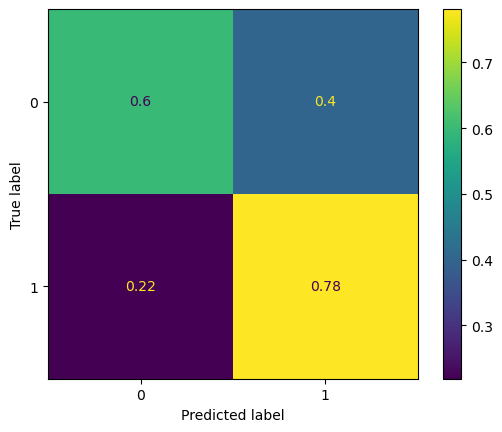

In [33]:
y_pred = grid.predict(X_test)


print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase


disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()

In [ ]:

param_grid = dict(kernel = ["linear", "poly","rbf","sigmoid"] )
grid = GridSearchCV(svc,param_grid, cv = 2, scoring="accuracy")

grid.fit(X_train_undersamp,y_train_undersamp)
# svc.fit(X_train_samp,y_train_samp)
# svc.fit(X_train_oversamp,y_train_oversamp)
# svc.fit(X_train,y_train)

y_pred = grid.predict(X_test)

NameError: name 'accuracy_score' is not defined

0.49666425528494496
[[0.49 0.51]
 [0.5  0.5 ]]


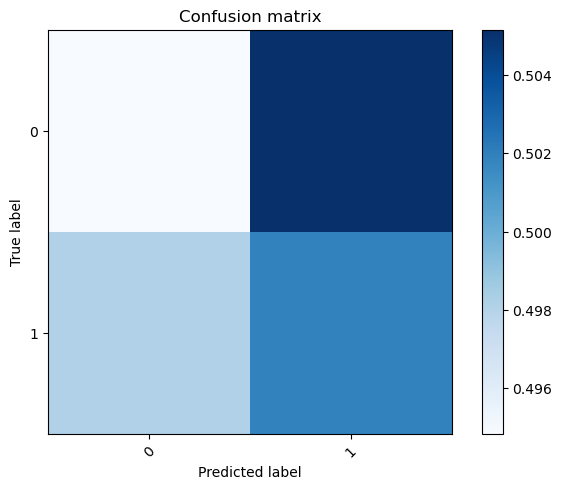

In [14]:
print(accuracy_score(y_true= y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred,normalize="true")
print(confu_mat.round(2))
plot_confusion_matrix(confu_mat,[0,1])